In [ ]:
# # Uninstall problematic packages
# !pip uninstall numpy pandas gymnasium torch torchvision -y

# Reinstall in correct order
!pip install "numpy<2.0"
!pip install pandas gymnasium torch torchvision
!pip install transformers scikit-learn matplotlib pillow


  Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached torchvision-0.22.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Using device: cuda
Creating V-JEPA 2 compatible pendulum video dataset...
Generating synthetic pendulum video sequences...


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 3/3 [00:00<00:00, 20.09it/s]

Dataset created with 279 video sequences
Initializing V-JEPA 2 physics analyzer...


Starting training...
Starting V-JEPA 2 physics training...


Epoch 1/3: 100%|██████████| 35/35 [07:45<00:00, 13.30s/batch, loss=9.72]


Epoch 1 completed, Avg Loss: 11.5655


Epoch 2/3: 100%|██████████| 35/35 [07:44<00:00, 13.28s/batch, loss=14.5]


Epoch 2 completed, Avg Loss: 11.2348


Epoch 3/3: 100%|██████████| 35/35 [07:44<00:00, 13.26s/batch, loss=9.38]


Epoch 3 completed, Avg Loss: 10.7839


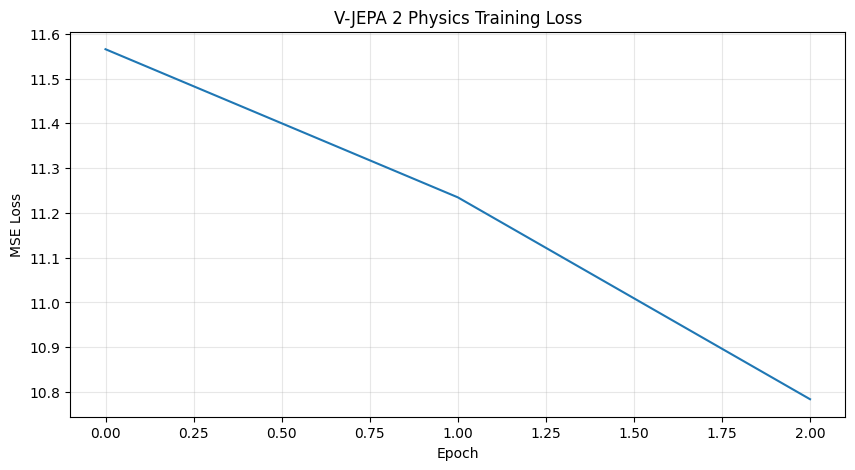

Analyzing V-JEPA 2 physics representations...


Extracting V-JEPA 2 embeddings: 100%|██████████| 18/18 [07:44<00:00, 25.82s/it]



V-JEPA 2 Latent -> Theta R²: 1.0000, MSE: 0.0000
V-JEPA 2 Latent -> Omega R²: 1.0000, MSE: 0.0000


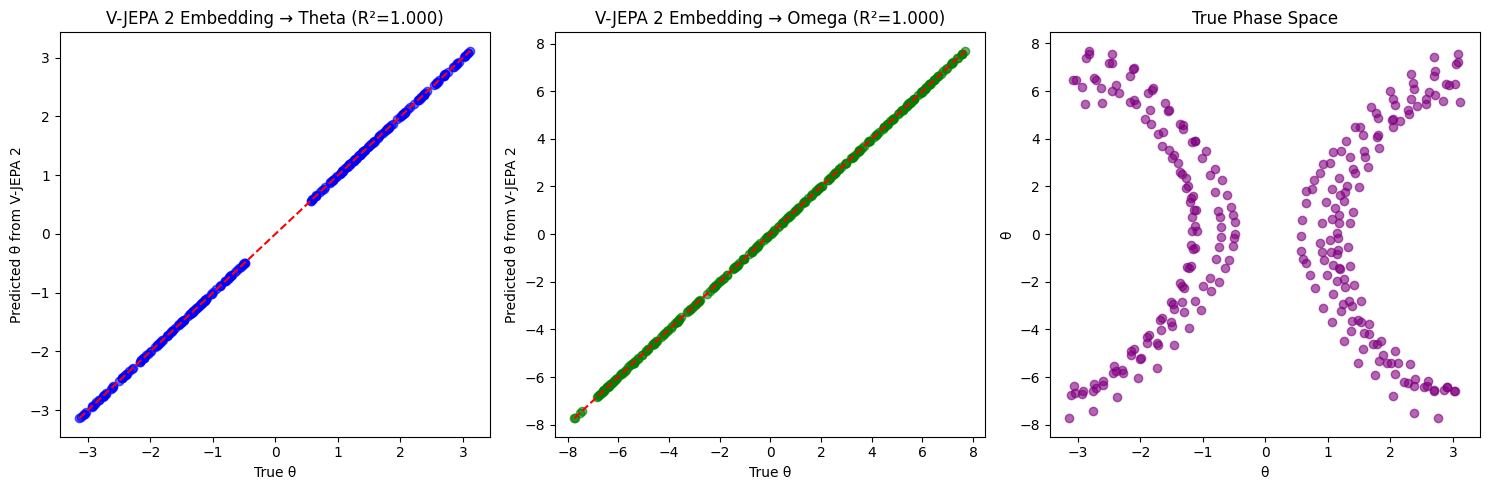

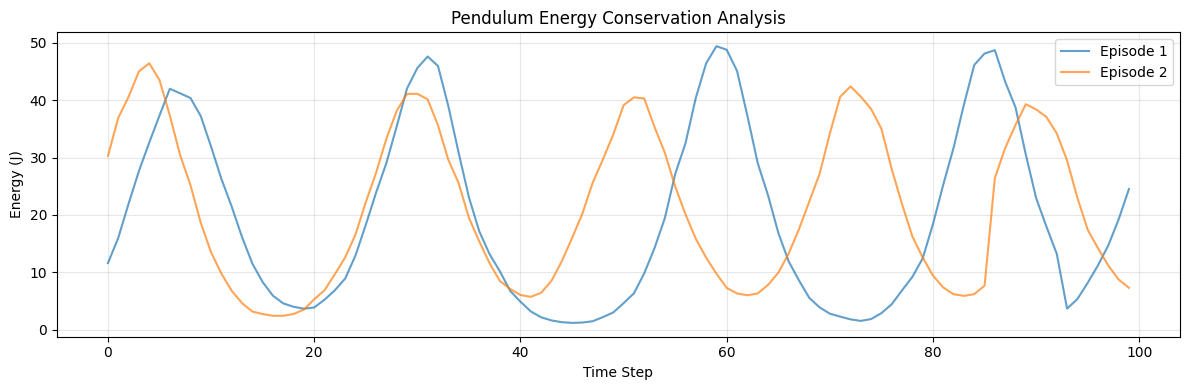

V-JEPA 2 physics analysis completed!


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gym
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoVideoProcessor, AutoModel
from torchcodec.decoders import VideoDecoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Enhanced Data Collection for Video Sequences
# ============================

class PendulumVideoDataset(Dataset):
    def __init__(self, num_episodes=50, episode_length=100, img_size=256, sequence_length=8, transform=None):
        """
        Dataset for pendulum video sequences compatible with V-JEPA 2

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to (V-JEPA 2 uses 256x256)
            sequence_length: Number of consecutive frames per sequence
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.sequence_length = sequence_length
        self.transform = transform

        # Generate synthetic pendulum video sequences
        self.generate_synthetic_pendulum_videos(num_episodes, episode_length)

    def generate_synthetic_pendulum_videos(self, num_episodes, episode_length):
        """Generate synthetic pendulum video sequences using PIL"""
        print("Generating synthetic pendulum video sequences...")

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.video_sequences = []
        self.labels_sequences = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]

            episode_frames = []
            episode_labels = []

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:
                    obs, reward, done, _ = step_result
                else:
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta and omega from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum components
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=4)
                draw.ellipse([(center_x-6, center_y-6), (center_x+6, center_y+6)], fill='red')
                draw.ellipse([(end_x-10, end_y-10), (end_x+10, end_y+10)], fill='blue')

                # Convert to numpy array
                img_array = np.array(img)
                episode_frames.append(img_array)
                episode_labels.append((theta, omega))

                if done:
                    break

            # Create video sequences from episode frames
            for i in range(len(episode_frames) - self.sequence_length + 1):
                video_seq = episode_frames[i:i + self.sequence_length]
                label_seq = episode_labels[i:i + self.sequence_length]

                self.video_sequences.append(np.array(video_seq))
                self.labels_sequences.append(label_seq)

        env.close()
        print(f"Dataset created with {len(self.video_sequences)} video sequences")

    def __len__(self):
        return len(self.video_sequences)

    def __getitem__(self, idx):
        video_seq = self.video_sequences[idx]  # [T, H, W, C]
        label_seq = self.labels_sequences[idx]

        # Convert to tensor and rearrange dimensions for V-JEPA 2: [T, C, H, W]
        video_tensor = torch.from_numpy(video_seq).float() / 255.0
        video_tensor = video_tensor.permute(0, 3, 1, 2)  # [T, C, H, W]

        # Extract labels from middle frame for analysis
        mid_frame_idx = len(label_seq) // 2
        label = torch.tensor(label_seq[mid_frame_idx], dtype=torch.float32)

        return video_tensor, label

# ============================
# 2. V-JEPA 2 Model Integration
# ============================

class VJEPA2PhysicsAnalyzer(nn.Module):
    """
    V-JEPA 2 based physics analyzer for pendulum dynamics
    """
    def __init__(self, model_name="facebook/vjepa2-vitl-fpc64-256", freeze_backbone=True):
        super().__init__()

        # Load pre-trained V-JEPA 2 model and processor
        self.processor = AutoVideoProcessor.from_pretrained(model_name)
        self.vjepa2_model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="auto" if torch.cuda.is_available() else None,
            attn_implementation="sdpa"
        )

        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.vjepa2_model.parameters():
                param.requires_grad = False

        # Physics prediction heads
        self.feature_dim = 1024  # V-JEPA 2 ViT-L embedding dimension
        self.physics_predictor = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2)  # theta and omega
        )

    def extract_features(self, video_batch):
        """Extract features from video batch using V-JEPA 2"""
        with torch.no_grad():
            batch_features = []

            for video in video_batch:
                # Ensure correct frame count (64 frames)
                if video.shape[0] < 64:
                    repeat_factor = (64 + video.shape[0] - 1) // video.shape[0]
                    video = video.repeat(repeat_factor, 1, 1, 1)[:64]
                elif video.shape[0] > 64:
                    indices = torch.linspace(0, video.shape[0] - 1, 64).long()
                    video = video[indices]

                # Convert to numpy for processor: T, H, W, C
                video_np = video.permute(0, 2, 3, 1).cpu().numpy()

                # Process with V-JEPA 2 processor
                processed_video = self.processor(
                    video_np,
                    return_tensors="pt"
                ).to(self.vjepa2_model.device)

                # Get features using correct API
                outputs = self.vjepa2_model(**processed_video)
                features = outputs.last_hidden_state.mean(dim=1)  # Average pool
                batch_features.append(features)

            # Stack all features
            features = torch.cat(batch_features, dim=0)

        return features

    def forward(self, video_batch):
        """Forward pass for physics prediction"""
        # Extract V-JEPA 2 features
        features = self.extract_features(video_batch)

        # Predict physics variables
        physics_pred = self.physics_predictor(features.float())

        return physics_pred, features

# ============================
# 3. Training Function
# ============================

def train_vjepa2_physics(model, train_loader, optimizer, num_epochs=20, log_interval=10):
    """Train the V-JEPA 2 based physics analyzer"""

    model.train()
    # Set V-JEPA 2 backbone to eval mode since it's frozen
    model.vjepa2_model.eval()

    losses = []

    print("Starting V-JEPA 2 physics training...")
    for epoch in range(num_epochs):
        epoch_loss = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for i, (videos, labels) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

                # Move to device
                videos = videos.to(device)
                labels = labels.to(device)

                # Forward pass
                physics_pred, _ = model(videos)

                # Compute loss
                loss = F.mse_loss(physics_pred, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update metrics
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}")

    return losses


# ============================
# 4. Physics Analysis Functions (Updated)
# ============================

def compute_energy(theta, omega, m=1.0, l=1.0, g=9.81):
    """Compute the total mechanical energy of the pendulum"""
    kinetic = 0.5 * m * (l**2) * omega**2
    potential = m * g * l * (1 - np.cos(theta))
    return kinetic + potential

def analyze_vjepa2_latent_phase_relation(model, dataset, batch_size=16, num_samples=500):
    """
    Analyze how V-JEPA 2 latent embeddings relate to physical phase space variables
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    latent_features = []
    theta_list = []
    omega_list = []

    count = 0
    for videos, labels in tqdm(loader, desc="Extracting V-JEPA 2 embeddings"):
        videos = videos.to(device)
        thetas, omegas = labels[:, 0], labels[:, 1]

        with torch.no_grad():
            _, features = model(videos)
            latent_features.append(features.cpu())

        theta_list.extend(thetas.numpy())
        omega_list.extend(omegas.numpy())

        count += videos.size(0)
        if count >= num_samples:
            break

    latent_features = torch.cat(latent_features, dim=0).numpy()[:num_samples]
    theta_array = np.array(theta_list[:num_samples]).reshape(-1, 1)
    omega_array = np.array(omega_list[:num_samples]).reshape(-1, 1)

    # Fit regressors
    reg_theta = LinearRegression().fit(latent_features, theta_array)
    reg_omega = LinearRegression().fit(latent_features, omega_array)

    theta_pred = reg_theta.predict(latent_features)
    omega_pred = reg_omega.predict(latent_features)

    # Metrics
    r2_theta = r2_score(theta_array, theta_pred)
    r2_omega = r2_score(omega_array, omega_pred)
    mse_theta = mean_squared_error(theta_array, theta_pred)
    mse_omega = mean_squared_error(omega_array, omega_pred)

    print(f"\nV-JEPA 2 Latent -> Theta R²: {r2_theta:.4f}, MSE: {mse_theta:.4f}")
    print(f"V-JEPA 2 Latent -> Omega R²: {r2_omega:.4f}, MSE: {mse_omega:.4f}")

    # Visualization
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(theta_array, theta_pred, alpha=0.6, c='blue')
    plt.xlabel("True θ")
    plt.ylabel("Predicted θ from V-JEPA 2")
    plt.title(f"V-JEPA 2 Embedding → Theta (R²={r2_theta:.3f})")
    plt.plot([theta_array.min(), theta_array.max()], [theta_array.min(), theta_array.max()], 'r--')

    plt.subplot(1, 3, 2)
    plt.scatter(omega_array, omega_pred, alpha=0.6, c='green')
    plt.xlabel("True θ̇")
    plt.ylabel("Predicted θ̇ from V-JEPA 2")
    plt.title(f"V-JEPA 2 Embedding → Omega (R²={r2_omega:.3f})")
    plt.plot([omega_array.min(), omega_array.max()], [omega_array.min(), omega_array.max()], 'r--')

    plt.subplot(1, 3, 3)
    plt.scatter(theta_array, omega_array, alpha=0.6, c='purple')
    plt.xlabel("θ")
    plt.ylabel("θ̇")
    plt.title("True Phase Space")

    plt.tight_layout()
    plt.savefig('vjepa2_physics_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_energy_conservation_analysis(dataset, episode_length=100):
    """Analyze energy conservation in pendulum episodes"""
    energies = []
    num_episodes = len(dataset) // episode_length

    for ep in range(min(num_episodes, 10)):  # Analyze first 10 episodes
        ep_thetas = []
        ep_omegas = []
        for i in range(episode_length):
            if ep * episode_length + i < len(dataset):
                _, label = dataset[ep * episode_length + i]
                ep_thetas.append(label[0].item())
                ep_omegas.append(label[1].item())

        if ep_thetas:
            theta_np = np.array(ep_thetas)
            omega_np = np.array(ep_omegas)
            energy = compute_energy(theta_np, omega_np)
            energies.append(energy)

    # Plot energy conservation
    plt.figure(figsize=(12, 4))
    for i, ep_energy in enumerate(energies):
        plt.plot(ep_energy, alpha=0.7, label=f'Episode {i+1}')

    plt.xlabel("Time Step")
    plt.ylabel("Energy (J)")
    plt.title("Pendulum Energy Conservation Analysis")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("energy_conservation_vjepa2.png", dpi=300, bbox_inches='tight')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # Configuration
    batch_size = 8  # Smaller due to video sequences and large model
    img_size = 256  # V-JEPA 2 standard resolution
    sequence_length = 8  # Frames per sequence
    learning_rate = 1e-4
    num_epochs = 3

    print("Creating V-JEPA 2 compatible pendulum video dataset...")
    dataset = PendulumVideoDataset(
        num_episodes=3,
        episode_length=100,
        img_size=64,
        sequence_length=8
    )

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    print("Initializing V-JEPA 2 physics analyzer...")
    model = VJEPA2PhysicsAnalyzer().to(device)

    # Create optimizer (only for prediction head since backbone is frozen)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate
    )

    print("Starting training...")
    losses = train_vjepa2_physics(model, train_loader, optimizer, num_epochs=num_epochs)

    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('V-JEPA 2 Physics Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig('vjepa2_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Analyzing V-JEPA 2 physics representations...")
    analyze_vjepa2_latent_phase_relation(model, dataset)
    plot_energy_conservation_analysis(dataset)

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses
    }, "vjepa2_physics_analyzer.pt")

    print("V-JEPA 2 physics analysis completed!")

if __name__ == "__main__":
    main()


## Works but too lengthy, might need to use gpus from MQube

I downgraded params just to run to see whats up